In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchaudio
import torchaudio.transforms as transforms
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([1, 128, 16538])


/home/yoshi/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


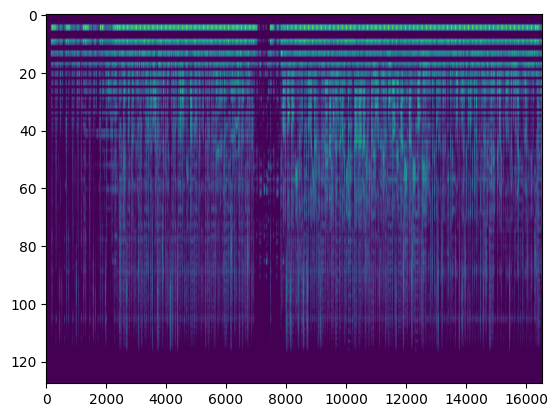

In [3]:
waveform, sample_rate = torchaudio.load(f'arashi_divide/1.mp3', normalize=True)
waveform = waveform.mean(dim=0, keepdim=True)
mel_transform = transforms.MelSpectrogram(
sample_rate=sample_rate,
n_fft=400,
hop_length=160,
n_mels=128
)
mel_spectrogram = mel_transform(waveform)

# スペクトログラムのデシベルスケール変換
db_transform = transforms.AmplitudeToDB(stype="magnitude", top_db=80)
data = db_transform(mel_spectrogram)
print(data.shape)
_ = plt.imshow(data[0], aspect="auto")

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(1, 259):
    waveform, sample_rate = torchaudio.load(f'arashi_divide/1.mp3', normalize=True)
    waveform = waveform.mean(dim=0, keepdim=True)
    mel_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=512,            # フーリエ変換のサイズを増やす
    hop_length=160,
    n_mels=64             # メルバンド数を増やす
    )
    mel_spectrogram = mel_transform(waveform).log()

    # スペクトログラムのデシベルスケール変換
    db_transform = transforms.AmplitudeToDB(stype="magnitude", top_db=80)
    data = db_transform(mel_spectrogram)
    if i % 5 != 0:
        X_train.append((data, 0))
    else:
        X_test.append((data, 0))
for i in range(1, 218):
    waveform, sample_rate = torchaudio.load(f'hsj_divide/1.mp3', normalize=True)
    waveform = waveform.mean(dim=0, keepdim=True)
    mel_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=512,            # フーリエ変換のサイズを増やす
    hop_length=160,
    n_mels=64             # メルバンド数を増やす
    )
    mel_spectrogram = mel_transform(waveform).log()

    # スペクトログラムのデシベルスケール変換
    db_transform = transforms.AmplitudeToDB(stype="magnitude", top_db=80)
    data = db_transform(mel_spectrogram)
    if i % 5 != 0:
        X_train.append((data, 1))
    else:
        X_test.append((data, 1))

/home/yoshi/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [5]:
print(X_train[0][0].shape)
print(X_test[0][0].shape)
print(len(X_train))
print(len(X_test))

torch.Size([1, 64, 16538])
torch.Size([1, 64, 16538])
381
94


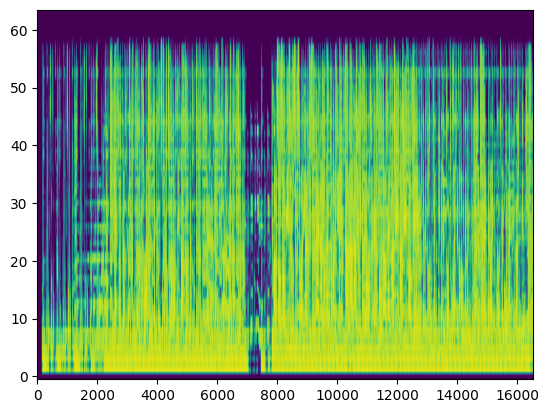

In [6]:
_ = plt.imshow(X_train[0][0][0], aspect="auto", origin="lower")

In [7]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        # 一旦仮のサイズを設定
        self.l1 = nn.Linear(1, n_hidden)  # ダミー値で一時的に設定
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.features(x)

        x = self.flatten(x)
        
        # フラット化後のサイズを取得して l1 を再定義（1度のみ）
        if not hasattr(self, "fc_input_size"):
            self.fc_input_size = x.shape[1]
            self.l1 = nn.Linear(self.fc_input_size, self.l1.out_features).to(x.device)  # デバイスも考慮
        
        x = self.l1(x)
        x = self.l2(x)
        return x


In [8]:
n_output = 2
n_hidden = 128
#モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [9]:
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss



In [10]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
 
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [11]:
train_loader = DataLoader(X_train, batch_size=10, shuffle=True)
test_loader = DataLoader(X_test, batch_size=10, shuffle=True)

In [12]:
# 損失計算
loss = eval_loss(test_loader, device, net, criterion)

# 損失の計算グラフ可視化


In [13]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.90208 acc: 0.94226 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00023 acc: 1.00000 val_loss: 0.00017, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00014 acc: 1.00000 val_loss: 0.00011, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00010 acc: 1.00000 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00008 acc: 1.00000 val_loss: 0.00007, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00007 acc: 1.00000 val_loss: 0.00006, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00006 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00005 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00004 acc: 1.00000 val_loss: 0.00004, val_acc: 1.00000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00004 acc: 1.00000 val_loss: 0.00004, val_acc: 1.00000


In [16]:
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

初期状態: 損失: 0.00031 精度: 1.00000
最終状態: 損失: 0.00004 精度: 1.00000


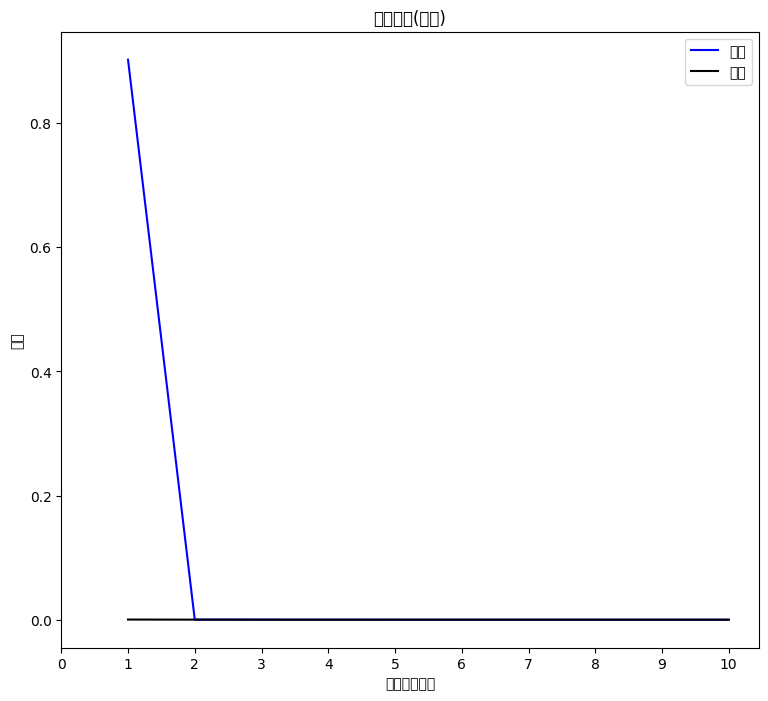

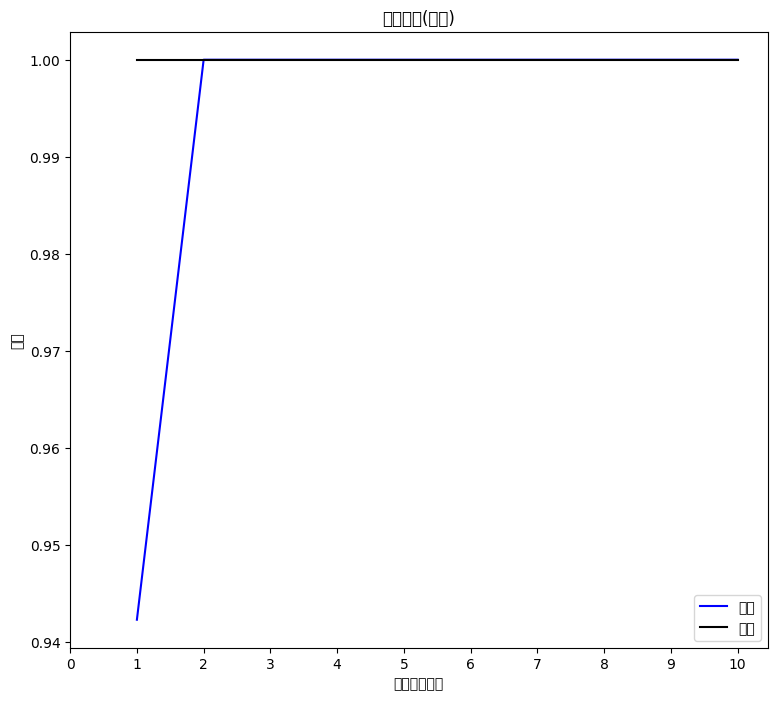

In [17]:
evaluate_history(history2)